# KIRC case study

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(ggsci)
library(ggpubr)
library(ggtext)
library(matrixStats)
library(msigdbr)
library(fgsea)
library(patchwork)
library(SummarizedExperiment)
source("trex_helper.r")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: MatrixGenerics


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeig

### Load TRex results

In [2]:
res_dir <- "../input"
cancer<-"KIRC"

In [3]:
analysis<-"condition.NoCovs"
res.files <- list.files(file.path(res_dir,cancer),pattern = "SE.res.condition.NoCovs.trex_countA*",recursive = F)
names(res.files)<-sub("\\.res.*","",res.files)%>%sub("/","_",.)
cond.nocov <- lapply(res.files,function(file,...){
                 res <- suppressWarnings(fread(file.path(res_dir,cancer,file),data.table=FALSE,stringsAsFactors = F,drop=1,nThread = 4))%>%
                         mutate(signif = padj<0.05) %>%                
                         mutate(cancer=cancer,
                                exp_var=sub(".*trex_countA\\.","",file) %>% sub("\\.tsv","",.)) %>%
                         select(-constitutive_transcripts,-alternative_transcripts,-seqname)    
               }) %>% do.call(rbind,.) %>%
               rename_at(vars(log2FoldChange:padj,signif),function(col){paste0(col,"_condition.noCov")} )

In [4]:
analysis<-"condition.NoCovs"
res.files <- list.files(file.path(res_dir,cancer),pattern = "SE.res.lfcShrink.condition.NoCovs.trex_countA*",recursive = F)
names(res.files)<-sub("\\.res.*","",res.files)%>%sub("/","_",.)
cond.nocov.lfsh <- lapply(res.files,function(file,...){
                 res <- suppressWarnings(fread(file.path(res_dir,cancer,file),data.table=FALSE,stringsAsFactors = F,drop=1,nThread = 4))%>%
                         mutate(signif = padj<0.05) %>%                
                         mutate(cancer=cancer,
                                exp_var=sub(".*trex_countA\\.","",file) %>% sub("\\.tsv","",.)) %>%
                         select(-constitutive_transcripts,-alternative_transcripts,-seqname)    
               }) %>% do.call(rbind,.) %>%
               rename_at(vars(log2FoldChange:padj,signif),function(col){paste0(col,"_condition.noCov")} ) %>%
               mutate(event_id=cond.nocov$event_id) 

In [5]:
analysis<-"condition"
res.files <- list.files(file.path(res_dir,cancer),pattern = "SE.res.condition.trex_countA*",recursive = F)
names(res.files)<-sub("\\.res.*","",res.files)%>%sub("/","_",.)
cond <- lapply(res.files,function(file,...){
                 res <- suppressWarnings(fread(file.path(res_dir,cancer,file),data.table=FALSE,stringsAsFactors = F,drop=1,nThread = 4))%>%
                        mutate(signif = padj<0.05) %>%                
                        mutate(cancer=cancer,
                                exp_var=sub(".*trex_countA\\.","",file) %>% sub("\\.tsv","",.)) %>%
                         select(-constitutive_transcripts,-alternative_transcripts,-seqname)    
        }) %>% do.call(rbind,.)%>%
        rename_at(vars(log2FoldChange:padj,signif),function(col){paste0(col,"_condition")} )%>%
        mutate(event_id = c(cond.nocov$event_id,cond.nocov$event_id,cond.nocov$event_id,cond.nocov$event_id))

In [6]:
analysis<-"condition"
res.files <- list.files(file.path(res_dir,cancer),pattern = "SE.res.lfcShrink.condition.trex_countA*",recursive = F)
names(res.files)<-sub("\\.res.*","",res.files)%>%sub("/","_",.)
cond.lfsh <- lapply(res.files,function(file,...){
                 res <- suppressWarnings(fread(file.path(res_dir,cancer,file),data.table=FALSE,stringsAsFactors = F,drop=1,nThread = 4))%>%
                        mutate(signif = padj<0.05) %>%                
                        mutate(cancer=cancer,
                                exp_var=sub(".*trex_countA\\.","",file) %>% sub("\\.tsv","",.)) %>%
                         select(-constitutive_transcripts,-alternative_transcripts,-seqname)    
        }) %>% do.call(rbind,.)%>%
        rename_at(vars(log2FoldChange:padj,signif),function(col){paste0(col,"_condition")} )%>%
        mutate(event_id = c(cond.nocov$event_id,cond.nocov$event_id,cond.nocov$event_id,cond.nocov$event_id))

In [7]:
load(file.path(res_dir,cancer,"SE.eventCounts.RData"),verbose = F)

In [8]:
cts.tumor<-trex.meta@assays@data$counts[unique(cond$event_id),trex.meta@colData$condition=="tumor"]
cts.normal<-trex.meta@assays@data$counts[unique(cond$event_id),trex.meta@colData$condition=="normal"]

psi.tumor<-cts.tumor[,grepl("A_",colnames(cts.tumor))]/(cts.tumor[,grepl("A_",colnames(cts.tumor))]+cts.tumor[,grepl("C_",colnames(cts.tumor))])
psi.normal<-cts.normal[,grepl("A_",colnames(cts.normal))]/(cts.normal[,grepl("A_",colnames(cts.normal))]+cts.normal[,grepl("C_",colnames(cts.normal))])

In [9]:
min.psi<-0.01 # threshold on PSI
max.inv.samples<-0.95 # max proportion of samples with invalid PSI values allowed
max.na.samples<-0.95 #max numer of NA samples

psi.stats<-data.frame(mean_psi_tumor = rowMeans(psi.tumor,na.rm = T),
                      mean_psi_normal = rowMeans(psi.normal,na.rm = T), 
                      na_tumor = rowSums(is.na(psi.tumor))/ncol(psi.tumor),
                      na_normal = rowSums(is.na(psi.normal))/ncol(psi.normal),
                      nun_low_tumor = (rowSums(psi.tumor <= min.psi,na.rm=T))/ncol(psi.tumor),
                      nun_low_normal = (rowSums(psi.normal <= min.psi,na.rm=T))/ncol(psi.normal),
                      nun_high_tumor = (rowSums((1-psi.tumor) <= min.psi,na.rm=T))/ncol(psi.tumor),
                      nun_high_normal = (rowSums((1-psi.normal) <= min.psi,na.rm=T))/ncol(psi.normal)) %>%
                mutate(pi_tumor = nun_low_tumor+nun_high_tumor+na_tumor,
                       pi_normal = nun_low_normal+nun_high_normal+na_normal,
                       p_na = na_tumor+na_normal) %>%
                select(-nun_low_tumor,-nun_low_normal,-nun_high_tumor,-nun_high_normal)

psi.stats<-psi.stats %>% 
            mutate(psi_flag = (mean_psi_tumor <= min.psi & mean_psi_normal <= min.psi) | ((1-mean_psi_tumor) <= min.psi & 1-mean_psi_normal),
                   samples_flag = (pi_tumor >= max.inv.samples & pi_normal >= max.inv.samples),
                   na_flag = (na_tumor >= max.na.samples & na_normal >= max.na.samples)) %>%
            mutate(event_flag = ifelse((psi_flag&samples_flag)|na_flag,"invalid","valid")) %>%
            tibble::rownames_to_column("event_id")

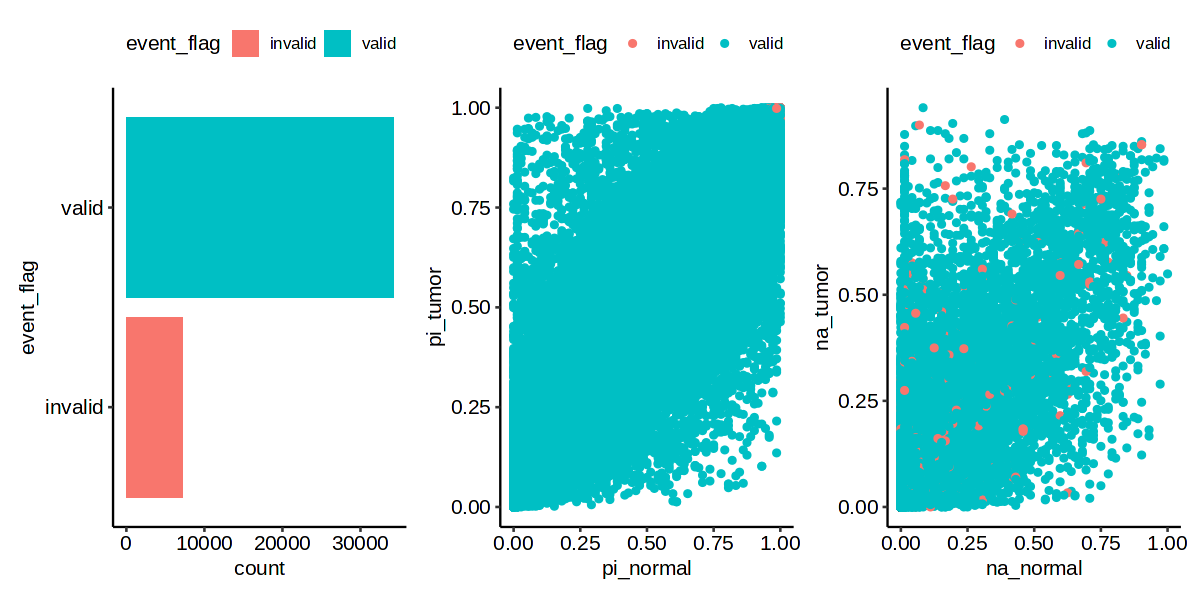

In [10]:
options(repr.plot.height=5,repr.plot.width=10)

p1<-psi.stats %>%
    ggplot(.,aes(x=event_flag,fill=event_flag))+
    geom_bar(stat="count")+
    coord_flip()+
    theme_pubr()+
    theme(legend.position="top")
p2<-psi.stats %>%
    ggplot(.,aes(x=pi_normal,y=pi_tumor,color=event_flag))+
    geom_point()+
    theme_pubr()
p3<-psi.stats %>%
    ggplot(.,aes(x=na_normal,y=na_tumor,color=event_flag))+
    geom_point()+
    theme_pubr()
p1+p2+p3

In [11]:
table(psi.stats$event_flag)


invalid   valid 
   7231   34177 

## Visualizations

#### Condition changes

In [12]:
cond.tumor <- cond %>% 
              filter(exp_var=="conditiontumor",!is.na(padj_condition)) %>%
              left_join(.,cond.nocov) %>%
              left_join(.,psi.stats)
cond.tumor.lfsh <- cond.lfsh %>% 
                  filter(exp_var=="conditiontumor",!is.na(padj_condition)) %>%
                  left_join(.,cond.nocov.lfsh) %>%
                  left_join(.,psi.stats)

Joining, by = c("event_id", "baseMean", "gene_id", "event_type", "cancer",
"exp_var")
Joining, by = "event_id"
Joining, by = c("baseMean", "gene_id", "event_type", "cancer", "exp_var",
"event_id")
Joining, by = "event_id"


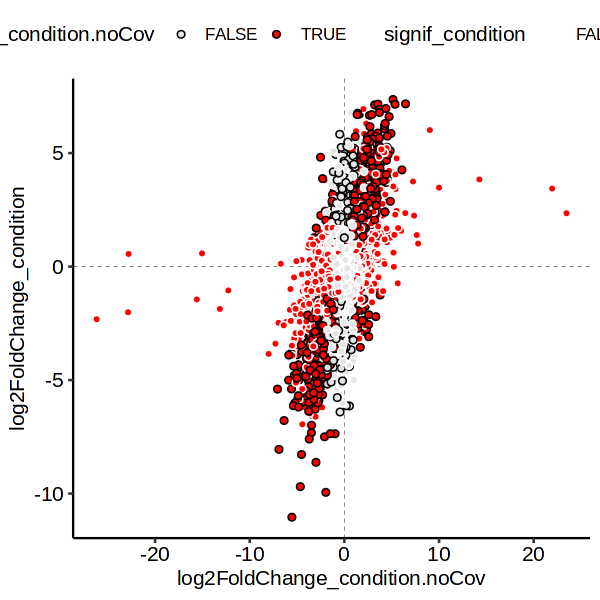

In [13]:
options(repr.plot.height=5,repr.plot.width=5)
p<-cond.tumor %>%
    filter(!is.na(signif_condition)&
           !is.na(signif_condition.noCov),
           event_flag=="valid")%>%
    ggplot(.,aes(y=log2FoldChange_condition,x=log2FoldChange_condition.noCov,
                 color=signif_condition,fill=signif_condition.noCov))+
        geom_hline(yintercept = 0,linewidth=0.1,linetype="dashed")+
        geom_vline(xintercept = 0,linewidth=0.1,linetype="dashed")+
        geom_point(pch=21,size=1.5)+
        scale_color_manual(values = c("#ffffff","#000000"))+
        scale_fill_manual(values = c("#E4E5E5","#FF0000"))+
        theme_pubr()
p

In [14]:
legend<-get_legend(p)%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/legend.condition.significance.scatterPlot.pdf",width = 8,height=0.5,units="in",device="pdf")

p<-p+theme(legend.position="none")
ggsave(plot=p,filename="../output/figures/condition.significance.scatterPlot.pdf",width = 4,height=4,units="in",device = "pdf")

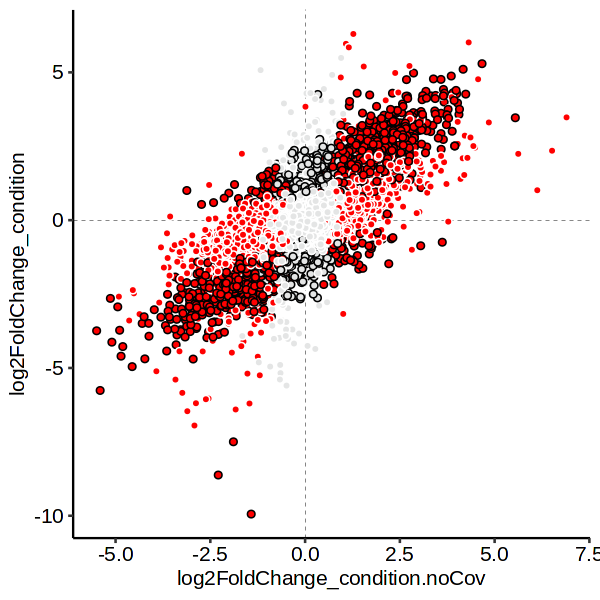

In [15]:
p<-cond.tumor.lfsh %>%
    filter(!is.na(signif_condition)&
           !is.na(signif_condition.noCov),
           event_flag=="valid")%>%
    ggplot(.,aes(y=log2FoldChange_condition,x=log2FoldChange_condition.noCov,
                 color=signif_condition,fill=signif_condition.noCov))+
        geom_hline(yintercept = 0,linewidth=0.1,linetype="dashed")+
        geom_vline(xintercept = 0,linewidth=0.1,linetype="dashed")+
        geom_point(pch=21,size=1.5)+
        scale_color_manual(values = c("#ffffff","#000000"))+
        scale_fill_manual(values = c("#E4E5E5","#FF0000"))+
        theme_pubr()
legend<-get_legend(p)%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/legend.condition.lfcShrink.significance.scatterPlot.pdf",width = 8,height=0.5,units="in",device="pdf")

p<-p+theme(legend.position="none")
ggsave(plot=p,filename="../output/figures/condition.lfcShrink.significance.scatterPlot.pdf",width = 4,height=4,units="in",device = "pdf")
p

#### Impurity changes

In [16]:
options(repr.plot.height=5,repr.plot.width=6.5)
var.cols<-c("conditiontumor"="#8E44AD","impurity"="#B9770E","age"="#17A589","sex1"="#D35400")
for(var in names(var.cols)){

    cond.imp <- cond.lfsh %>% 
                  filter(exp_var==var,!is.na(padj_condition)) %>%
                  left_join(.,psi.stats)

    p<-cond.imp %>%
        filter(!is.na(signif_condition),
               event_flag=="valid")%>%
        ggplot(.,aes(x=log2FoldChange_condition,y=-log10(padj_condition),color=signif_condition))+
            geom_hline(yintercept = -log10(0.05),linewidth=0.1,linetype="dashed")+
            geom_vline(xintercept = 0,linewidth=0.1,linetype="dashed")+
            geom_point(size=1)+
            scale_color_manual(values = c("#D2D2D2",as.character(var.cols[var])))+
            theme_pubr()+
            theme(legend.position="top")+
            labs(x=paste("dLogitPSI"),y="-log10(padj)")

    legend<-get_legend(p)%>%as_ggplot(.)
    ggsave(plot=legend,filename = paste0("../output/figures/legend.",var,".condition.volcano.pdf"),width = 8,height=0.5,units="in",device="pdf")

    p<-p+theme(legend.position="none")
    ggsave(plot=p,filename=paste0("../output/figures/",var,".condition.volcano.pdf"),width = 4,height=4,units="in",device = "pdf")
}


Joining, by = "event_id"
Joining, by = "event_id"
Joining, by = "event_id"
Joining, by = "event_id"


### Classify events 

In [17]:
cat.colors<-c("#5B2C6F","#8E44AD","#D2B4DE","#F5B041","#16A085")

#### Condition changes

In [18]:
options(repr.plot.height=5,repr.plot.width=5)
cond.tumor <- cond.tumor.lfsh %>%
               mutate(gene_group = case_when(signif_condition & signif_condition.noCov & sign(log2FoldChange_condition.noCov)==sign(log2FoldChange_condition) ~ "cancer",
                                             signif_condition & signif_condition.noCov & sign(log2FoldChange_condition.noCov)!=sign(log2FoldChange_condition) ~ "cancer_flipped",
                                             signif_condition.noCov & !signif_condition ~ "potential_false_pos",
                                             !signif_condition.noCov & signif_condition ~ "cancer_confounded",
                                             TRUE ~ "NS")) %>%
               mutate(gene_group = factor(gene_group,levels = c("cancer","cancer_flipped","cancer_confounded","potential_false_pos","NS")))

cond.tumor.ora <- cond.tumor %>% 
                   filter(event_flag == "valid") %>%
                   mutate(gene_id = sub("\\..*","",gene_id)) %>%
                   filter(!is.na(signif_condition)&!is.na(signif_condition.noCov)) 

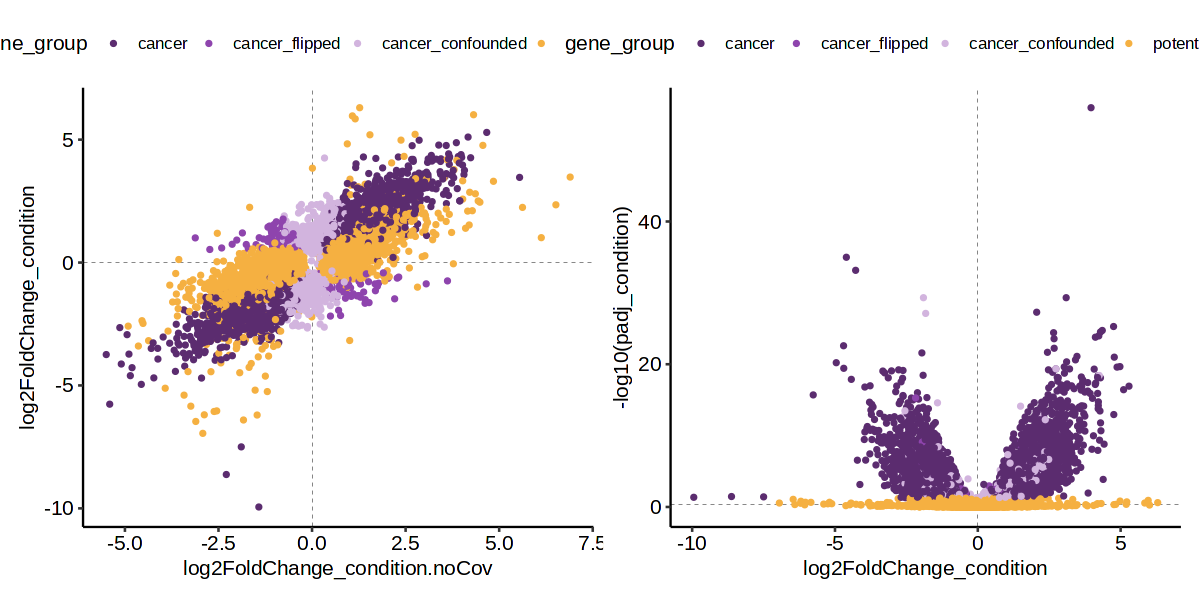

In [19]:
options(repr.plot.height=5,repr.plot.width=10)
p2<-cond.tumor.ora %>%
    filter(gene_group!="NS") %>%
    ggplot(.,aes(y=log2FoldChange_condition,x=log2FoldChange_condition.noCov,
                 color=gene_group))+
    geom_hline(yintercept = 0,linewidth=0.1,linetype="dashed")+
    geom_vline(xintercept = 0,linewidth=0.1,linetype="dashed")+
    geom_point(size=1)+
    scale_color_manual(values=cat.colors)+
    theme_pubr()
p3<-cond.tumor.ora %>%
    filter(gene_group!="NS") %>%
    ggplot(.,aes(x=log2FoldChange_condition,y=-log10(padj_condition),color=gene_group))+
    geom_hline(yintercept = -log10(0.5),linewidth=0.1,linetype="dashed")+
    geom_vline(xintercept = 0,linewidth=0.1,linetype="dashed")+
    geom_point(size=1)+
    scale_color_manual(values=cat.colors)+
    theme_pubr()
p2+p3

In [20]:
legend<-get_legend(p2)%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/legend.condition.significance.scatterPlot.byGeneGroup.pdf",width = 8,height=0.5,units="in",device="pdf")
p2<-p2+theme(legend.position="none")
ggsave(plot=p2,filename="../output/figures/condition.significance.scatterPlot.byGeneGroup.pdf",width = 4,height=4,units="in",device = "pdf")
p3<-p3+theme(legend.position="none")
ggsave(plot=p3,filename="../output/figures/condition.volcanoPlot.byGeneGroup.pdf",width=4,height=4,units="in",device = "pdf")

#### Store figure data

In [21]:
cond.tumor.ora <- cond.tumor.ora %>% 
                   mutate(direction=ifelse(log2FoldChange_condition>0,"up","down"))
write.table(cond.tumor.ora,file = "../output/tables/Figure9_KIRC.res.lfcShrink.condition.trexCount.tsv",row.names = F,col.names = T,quote = F,sep="\t")

In [22]:
cond.imp.ora <- cond.imp %>%
                 mutate(direction=ifelse(log2FoldChange_condition>0,"up","down"))
write.table(cond.imp.ora,file = "../output/tables/Figure9_KIRC.res.lfcShrink.impurity.trexCount.tsv",row.names = F,col.names = T,quote = F,sep="\t")